### Step 1: Install necesscary packages

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib
!pip install torch numpy transformers datasets tiktoken wandb tqdm
#%pip uninstall -y torch torchvision torchaudio
#%pip install --index-url https://download.pytorch.org/whl/cu124 torch torchvision torchaudio

ERROR: Operation cancelled by user


### Step 2: Package imports and configuration

In [69]:
!nvidia-smi

Mon Oct 20 15:31:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             63W /  400W |    3093MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [70]:
!ls
%cd /content/drive/MyDrive/Colab Notebooks/Lab-1 NEW/SC3000_TECD2_Lab1_NanoGPT-Math-NEW
!ls

configurator.py  data  dpo  model.py  __pycache__  README.md  sft
/content/drive/MyDrive/Colab Notebooks/Lab-1 NEW/SC3000_TECD2_Lab1_NanoGPT-Math-NEW
configurator.py  data  dpo  model.py  __pycache__  README.md  sft


In [71]:
import sys
import os
sys.path.append(os.path.abspath(".."))
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pickle
from model import GPT, GPTConfig
import random
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt

# Configuration
beta = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 2e-4
epochs = 10
batch_size = 64
max_length = 64
num_samples = 1
max_new_tokens = 200
temperature = 0.1
top_k = None

print(device)

print("torch cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    import subprocess
    print("device name:", torch.cuda.get_device_name(0))
    x = torch.randn(8192, 8192, device="cuda")
    y = x @ x
    print("tensor on:", y.device)
    subprocess.run(["nvidia-smi"])

# tokenizer
with open("sft/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])



cuda
torch cuda available: True
device count: 1
device name: NVIDIA A100-SXM4-80GB
tensor on: cuda:0


### Step 3: Define helper functions

In [72]:
def compute_logprob(input_ids):
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]
    logits, _ = gpt(inputs, full_seq=True)
    B, T, V = logits.size()
    logits_flat = logits.reshape(-1, V)
    targets_flat = targets.reshape(-1)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=0, reduction='none')
    loss = loss.reshape(B, T)
    attention_mask = (targets != 0).float()
    loss = (loss * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
    return -loss

def pad_or_truncate(seq, max_length):
    return seq[-max_length:] if len(seq) > max_length else seq + [0] * (max_length - len(seq))

def get_batches(lines, batch_size):
    random.shuffle(lines)
    #for l in lines:
    #    print(l[1])
    for i in range(0, len(lines), batch_size):
        batch = lines[i:i+batch_size]
        if len(batch) < batch_size:
            continue
        neg_inputs = [pad_or_truncate(encode(p['negative'] + '\n\n\n\n'), max_length) for p in batch]
        pos_inputs = [pad_or_truncate(encode(p['positive'] + '\n\n\n\n'), max_length) for p in batch]
        neg_tensor = torch.tensor(neg_inputs, dtype=torch.long, device=device)
        pos_tensor = torch.tensor(pos_inputs, dtype=torch.long, device=device)
        yield neg_tensor, pos_tensor

### Step 4: Load the pretrained NanoGPT model

In [73]:
ckpt = torch.load("sft/gpt.pt", map_location=device)
gptconf = GPTConfig(**ckpt['model_args'])
gpt = GPT(gptconf)
state_dict = ckpt['model']
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
gpt.to(device).train()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(74, 348)
    (wpe): Embedding(256, 348)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=348, out_features=1044, bias=False)
          (c_proj): Linear(in_features=348, out_features=348, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=348, out_features=1392, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1392, out_features=348, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=348, out_features=74, bias=False)
)

### Step 5: Load Data (**students are required to complete this part!**)

In [74]:
# Load data from ./data/pos_neg_pairs.json
import random, json, re

# ---------------- Config ----------------
TOTAL = 250000            # start small; scale after you confirm learning
SEED = 20251020
random.seed(SEED)

# Ratios for Phase A (basic only)
RATIOS = {
    "arithmetic_1step": 0.60,
    "linear_eqn":       0.40,

    # keep these OFF for now (Phase B later)
    "expression_2steps": 0.00,
    "edge_cases":        0.00,
}

# Range limits (tight first)
A_B_RANGE = (1, 50)     # operands for arithmetic
X_K_B_RANGE = (1, 20)   # x, k, b for linear

# ---------------- Helpers ----------------
def gen_arithmetic():
    a = random.randint(*A_B_RANGE)
    b = random.randint(*A_B_RANGE)
    op = random.choice(['+','-','*','/'])
    if op == '/':
        # choose b dividing a to keep integer result
        divisors = [d for d in range(1, A_B_RANGE[1]+1) if a % d == 0]
        b = random.choice(divisors) if divisors else 1
        ans = a // b
    elif op == '+': ans = a + b
    elif op == '-': ans = a - b
    else:           ans = a * b
    prompt = f"{a}{op}{b}=?"
    pos = f"{prompt} The answer is {ans} because {a}{op}{b} equals {ans}."
    # a plausible but wrong negative or a refusal
    if random.random() < 0.5:
        wrong = ans + random.choice([-3, -2, -1, 1, 2, 3])
        neg = f"{prompt} The answer is {wrong}."
    else:
        neg = f"{prompt} Sorry, I do not know!"
    return {"negative": neg, "positive": pos}

def gen_linear():
    # Three patterns: x+b=c, x-b=c, k*x=c
    pat = random.choice([0,1,2])
    if pat in (0,1):
        x = random.randint(*X_K_B_RANGE)
        b = random.randint(*X_K_B_RANGE)
        if pat == 0:
            c = x + b
            prompt = f"x+{b}={c},x=?"
        else:
            c = x - b
            prompt = f"x-{b}={c},x=?"
        ans = x
        pos = f"{prompt} The answer is {ans} because {c}{'-' if pat==0 else '+'}{b} equals {ans}."
    else:
        k = random.randint(1, X_K_B_RANGE[1])
        x = random.randint(*X_K_B_RANGE)
        c = k * x
        prompt = f"{k}*x={c},x=?"
        ans = x
        pos = f"{prompt} The answer is {ans} because {c}/{k} equals {ans}."
    # negatives
    if random.random() < 0.5:
        wrong = ans + random.choice([-3,-2,-1,1,2,3])
        neg = f"{prompt} The answer is {wrong}."
    else:
        neg = f"{prompt} Sorry, I do not know!"
    return {"negative": neg, "positive": pos}

# (Phase B) 2-steps & edge cases — keep disabled until base works
def gen_expression_2steps():
    a,b,c = [random.randint(1,9) for _ in range(3)]
    op1, op2 = random.choice(['+','-','*']), random.choice(['+','-','*'])
    prompt = f"{a}{op1}({b}{op2}{c})=?"
    ans = eval(f"{a}{op1}({b}{op2}{c})")
    pos = f"{prompt} The answer is {ans}."
    neg = f"{prompt} Sorry, I do not know!"
    return {"negative": neg, "positive": pos}

def gen_edge_cases():
    # simple negatives only; keep tight
    a = random.randint(-20, 20)
    b = random.randint(-20, 20)
    op = random.choice(['+','-','*'])
    prompt = f"{a}{op}{b}=?"
    ans = eval(f"{a}{op}{b}")
    pos = f"{prompt} The answer is {ans}."
    neg = f"{prompt} Sorry, I do not know!"
    return {"negative": neg, "positive": pos}

GENS = {
    "arithmetic_1step": gen_arithmetic,
    "linear_eqn": gen_linear,
    "expression_2steps": gen_expression_2steps,
    "edge_cases": gen_edge_cases,
}

def build_dataset(total=TOTAL, ratios=RATIOS):
    data = []
    for k, r in ratios.items():
        n = int(total * r)
        if n <= 0: continue
        for _ in range(n):
            data.append(GENS[k]())
    random.shuffle(data)
    return data

data = build_dataset()
print(f"Generated: {len(data)} pairs")

# ---------------- Validation ----------------
arith_re = re.compile(r'^(-?\d+)([+\-*/])(-?\d+)=\?$')
lin_add  = re.compile(r'^x\+(-?\d+)=(-?\d+),x=\?$')
lin_sub  = re.compile(r'^x\-(-?\d+)=(-?\d+),x=\?$')
lin_mul  = re.compile(r'^(\d+)\*x=(-?\d+),x=\?$')

def extract_prompt(s):
    # get the part before the first space
    return s.split(' ', 1)[0]

def check_positive_record(rec):
    # Ensure the positive actually contains the correct number
    s = rec["positive"]
    prompt = extract_prompt(s)

    m = arith_re.match(prompt)
    if m:
        a, op, b = int(m.group(1)), m.group(2), int(m.group(3))
        ans = a+b if op=='+' else a-b if op=='-' else a*b if op=='*' else (a//b)
    else:
        m1 = lin_add.match(prompt)
        m2 = lin_sub.match(prompt)
        m3 = lin_mul.match(prompt)
        if m1:
            b, c = int(m1.group(1)), int(m1.group(2))
            ans = c - b
        elif m2:
            b, c = int(m2.group(1)), int(m2.group(2))
            ans = c + b
        elif m3:
            k, c = int(m3.group(1)), int(m3.group(2))
            ans = c // k
        else:
            # Other types are Phase B; skip strict check for now
            return True

    return f" {ans}" in s  # simple containment check for the number

bad = [i for i,rec in enumerate(data) if not check_positive_record(rec)]
print(f"Positives passing numeric sanity: {len(data)-len(bad)}/{len(data)}")
if bad[:5]: print("First few suspicious indices:", bad[:5])

# ---------------- Save ----------------
import os
os.makedirs("./data", exist_ok=True)
path = "./data/pos_neg_pairs.json"
with open(path, "w") as f:
    json.dump(data, f, indent=2)
print(f"✅ Saved {path}")

Generated: 250000 pairs
Positives passing numeric sanity: 250000/250000
✅ Saved ./data/pos_neg_pairs.json


In [75]:
# recommend to use the AdamW optimizer
# Load data from ./data/pos_neg_pairs.json
import json
!ls
path = "./data/pos_neg_pairs.json"
with open(path, "r", encoding="utf-8") as f:
    lines = json.load(f)

print(f"Loaded {len(lines)} training pairs")

configurator.py  data  dpo  model.py  __pycache__  README.md  sft
Loaded 250000 training pairs


### Step 6: Build the optimizer and scheduler (**students are required to complete this part!**)

In [76]:
# recommend to use the AdamW optimizer

import math
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

steps_per_epoch = max(1, len(lines) // batch_size)
total_training_steps = steps_per_epoch * epochs

#warmup_iters = int(0.05 * total_training_steps)  # 5% warmup
warmup_iters = int(0.05 * total_training_steps)  # try 50% on third try, same warmup as run 2
lr_decay_iters = total_training_steps
#min_lr = base_lr * 0.1
min_lr = base_lr * 0.05 # try lower min_lr


'''
optimizer = AdamW(
    gpt.parameters(),
    lr=base_lr,
    betas=(0.9, 0.95), #(0.9, 0.95)
    weight_decay=0.01 #1e-1=0.1
)

def lr_lambda(step):
    if step < warmup_iters:
        return float(step) / float(max(1, warmup_iters))
    elif step < lr_decay_iters:
        progress = float(step - warmup_iters) / float(max(1, lr_decay_iters - warmup_iters))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    else:
        return float(min_lr) / float(base_lr)
'''

# === AdamW with proper decay ===
decay, no_decay = [], []
for n, p in gpt.named_parameters():
    if not p.requires_grad:
        continue
    if n.endswith("bias") or "ln" in n.lower() or "layernorm" in n.lower():
        no_decay.append(p)
    else:
        decay.append(p)

gpt.to(device)

optimizer = AdamW(
    [{"params": decay, "weight_decay": 0.1},
     {"params": no_decay, "weight_decay": 0.0}],
    lr=base_lr,
    betas=(0.9, 0.999),
    eps=1e-8,
)

# cosine with warmup
def lr_lambda(step):
    if step < warmup_iters:
        return step / max(1, warmup_iters)
    progress = (step - warmup_iters) / max(1, lr_decay_iters - warmup_iters)
    return max(min_lr / base_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

#scheduler = LambdaLR(optimizer, lr_lambda)
print("Optimizer and scheduler ready.")

import pickle

with open("sft/meta.pkl","rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# robust encode/decode: map any OOV char to PAD/NULL (prefer '\x00' if it exists)
PAD_ID = stoi.get('\x00', 0)

def encode(s: str):
    return [stoi.get(ch, PAD_ID) for ch in s]

def decode(ids):
    return ''.join(itos[i] for i in ids)

Optimizer and scheduler ready.


### Step 7: Begin training (**students are required to complete this part!**)

In [77]:
''' # GIVEN
total_steps = len(lines) // batch_size
for epoch in range(epochs):
    pbar = tqdm(get_batches(lines, batch_size))
    for step, (neg_tensor,pos_tensor) in enumerate(pbar):
        ###########################################################
        # Please complete the training code here!
        # Examples:
        # ...
        # neg_logprob
        # pos_logprob
        # loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1
        # ...
        ###########################################################
    ckpt_path = f"./dpo.pt"
    torch.save({
        "model_state_dict": gpt.state_dict(),
        "model_args": ckpt['model_args'],
    }, ckpt_path)
    print(f"Saved checkpoint to {ckpt_path}")
'''

total_steps = len(lines) // batch_size

#################################################
# Want to look at learning rate and loss n plot graph
loss_history = []
lr_history = []
#################################################

for epoch in range(epochs):
    pbar = tqdm(get_batches(lines, batch_size))
    for step, (neg_tensor,pos_tensor) in enumerate(pbar):
        ###########################################################
        # Please complete the training code here!
        # Examples:
        # ...
        # neg_logprob
        # pos_logprob
        # loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1
        # ...
        # Move tensors to device
        neg_tensor = neg_tensor.to(device)
        pos_tensor = pos_tensor.to(device)

        # Compute log-probabilities via your helper
        pos_logprob = compute_logprob(pos_tensor)
        neg_logprob = compute_logprob(neg_tensor)

        # DPO preference loss: encourage pos > neg
        loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() \
               - pos_logprob.mean() * 0.1

        ### Want to look at learning rate and loss n plot graph
        loss_val = loss.item()
        loss_history.append(loss_val)

        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        ###

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(gpt.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        # Optionally record or display
        loss_val = loss.item()
        pbar.set_postfix({"loss": loss_val})
        ###########################################################
    ckpt_path = f"dpo/dpo.pt"
    torch.save({
        "model_state_dict": gpt.state_dict(),
        "model_args": ckpt['model_args'],
    }, ckpt_path)
    print(f"Saved checkpoint to {ckpt_path}")

3906it [02:55, 22.20it/s, loss=0.0206]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.22it/s, loss=0.0172]


Saved checkpoint to dpo/dpo.pt


3906it [02:56, 22.17it/s, loss=0.0147]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.23it/s, loss=0.014]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.24it/s, loss=0.0143]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.27it/s, loss=0.0141]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.23it/s, loss=0.0141]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.26it/s, loss=0.014]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.24it/s, loss=0.0138]


Saved checkpoint to dpo/dpo.pt


3906it [02:55, 22.26it/s, loss=0.0139]


Saved checkpoint to dpo/dpo.pt


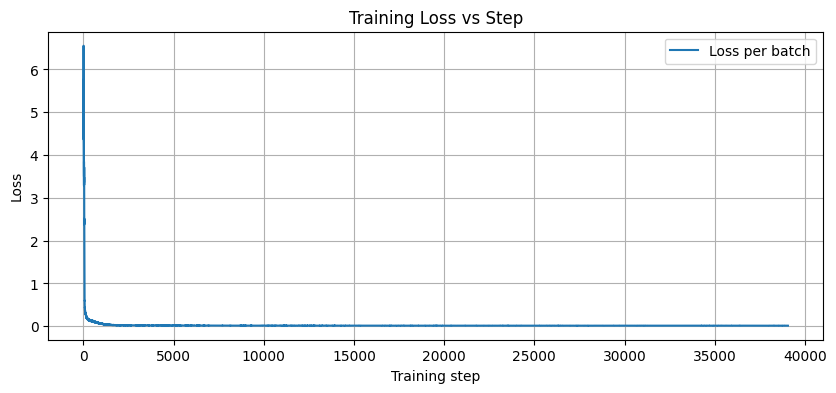

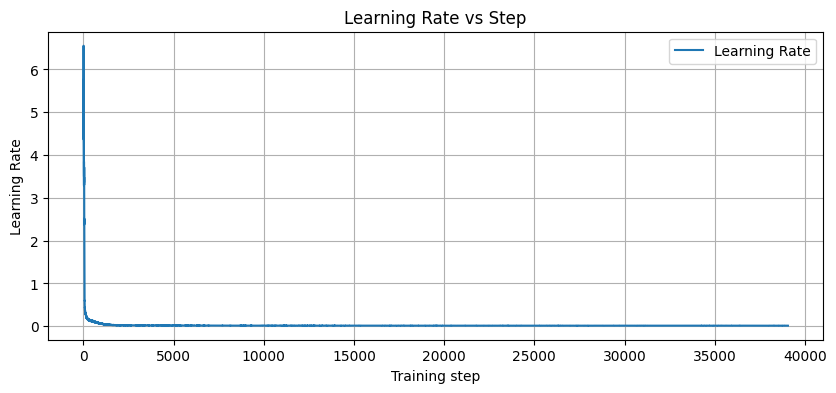

In [78]:
import matplotlib.pyplot as plt

# Plot training loss per step
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Loss per batch")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss vs Step")
plt.legend()
plt.grid(True)
plt.show()

# Plot average loss per epoch, if you recorded it
if 'epoch_loss_history' in globals():
    plt.figure(figsize=(6, 4))
    plt.plot(epoch_loss_history, marker='o', label="Avg loss per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Epoch-wise Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot learning rate schedule
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Learning Rate")
plt.xlabel("Training step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Step")
plt.legend()
plt.grid(True)
plt.show()


### Step 8: Begin testing (**students are required to complete this part!**)

In [80]:
# Load the fine-tuned model
ckpt_path = "dpo/dpo.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
device = 'cuda' if torch.cuda.is_available() else 'cpu' # apple
#gpt = GPT(gptconf).cuda()
gpt = GPT(gptconf).to(device)

try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
# Test
gpt.eval()
test_set = ["17+19=?", "3*17=?", "72/4=?", "72-x=34,x=?", "x*11=44,x=?", "3*17=?", "72/4=?", "72-x=34,x=?", "8+12=?", "50-23=?", "9*8=?", "81/9=?", "x+15=30,x=?", "7*x=49,x=?", "5*6=?", "100/25=?", "x-7=15,x=?", "9+x=20,x=?", "12*12=?", "64/8=?", "x+9=18,x=?", "10*10=?", "45/5=?", "x-4=10,x=?", "x+7=14,x=?", "6*7=?", "81/9=?", "x-3=12,x=?", "8+x=15,x=?", "14*14=?", "72/8=?", "x+8=16,x=?", "9-3=?", "15*3=?", "81/9=?", "x-5=10,x=?", "x+6=13,x=?", "11*11=?", "56/7=?", "x+10=20,x=?", "7*8=?", "90/9=?", "x-2=8,x=?", "x+5=12,x=?", "13*13=?", "72/6=?", "x-6=14,x=?", "4*9=?", "81/9=?", "x+4=10,x=?", "8*8=?", "60/5=?", "x-1=9,x=?", "x+3=11,x=?", "9*9=?", "49/7=?", "x-4=11,x=?", "6*6=?", "100/10=?", "x+2=12,x=?", "15-7=?", "8*7=?", "72/9=?", "x-8=12,x=?", "x+1=10,x=?", "14*12=?", "54/6=?", "x-9=11,x=?", "5*8=?", "81/9=?", "x+12=20,x=?", "7*9=?", "80/8=?", "x-7=13,x=?", "x+11=22,x=?", "12*11=?", "63/7=?", "x-5=15,x=?", "9*7=?", "90/10=?", "x+15=25,x=?", "6*8=?", "72/8=?", "x-4=16,x=?", "x+14=28,x=?", "11*12=?", "48/6=?", "x-3=13,x=?", "4*8=?", "56/8=?", "x+13=26,x=?", "10*12=?", "70/7=?", "x-6=18,x=?", "x+9=19,x=?"]
with torch.no_grad():
    for prompt in test_set:
        prompt_ids = encode(prompt)
        ###########################################################
        # Please complete the test code here!
        # ...
        # gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        # ...
        ###########################################################

        x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, :]

        y = gpt.generate(
            x,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=top_k
        )
        #output = decode(y[0].tolist())
############################################################
        lst = y[0].tolist()
        # handle nested list
        if len(lst) == 1 and isinstance(lst[0], list):
            lst = lst[0]
        output = decode(lst)
############################################################
        print(f"PROMPT : {prompt}")
        print(f"OUTPUT : {output}")
        print("-" * 30)
        ###########################################################

PROMPT : 17+19=?
OUTPUT : 17+19=? The answer is 36 because 17+19 equals 36.
------------------------------
PROMPT : 3*17=?
OUTPUT : 3*17=? The answer is 51 because 3*17 equals 51.
------------------------------
PROMPT : 72/4=?
OUTPUT : 72/4=? The answer is 7 because 72/4 equals 7.
------------------------------
PROMPT : 72-x=34,x=?
OUTPUT : 72-x=34,x=? The answer is 16 because 34-7 equals 6.
------------------------------
PROMPT : x*11=44,x=?
OUTPUT : x*11=44,x=? The answer is 4 because 44/11 equals 4.
------------------------------
PROMPT : 3*17=?
OUTPUT : 3*17=? The answer is 51 because 3*17 equals 51.
------------------------------
PROMPT : 72/4=?
OUTPUT : 72/4=? The answer is 7 because 72/4 equals 7.
------------------------------
PROMPT : 72-x=34,x=?
OUTPUT : 72-x=34,x=? The answer is 16 because 34-7 equals 6.
------------------------------
PROMPT : 8+12=?
OUTPUT : 8+12=? The answer is 20 because 8+12 equals 20.
------------------------------
PROMPT : 50-23=?
OUTPUT : 50-23=? The 